In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.linear_model import LinearRegression
from workflow.tools.utils import set_plot_style
from tqdm.auto import tqdm
from datetime import datetime as dt

from warnings import filterwarnings

filterwarnings("ignore")
set_plot_style()

In [2]:
stocks = [
    "AAPL",   # Apple Inc.
    "MSFT",   # Microsoft Corporation
    "AMZN",   # Amazon.com Inc.
    "GOOGL",  # Alphabet Inc. (Google) - Class A shares
    "META",   # Meta Platforms, Inc. (formerly Facebook)
    "BRK-B",  # Berkshire Hathaway Inc. - Class B shares
    "JNJ",    # Johnson & Johnson
    "V",      # Visa Inc.
    "WMT",    # Walmart Inc.
    "PG",     # Procter & Gamble Co.
    "JPM",    # JPMorgan Chase & Co.
    "NVDA",   # NVIDIA Corporation
    "DIS",    # The Walt Disney Company
    "HD",     # The Home Depot, Inc.
    "MA"      # Mastercard Incorporated
]

etfs = ["SPY"]

start = "2015-10-11"
end = "2017-10-11"

stock_prices = yf.download(stocks, start, end)["Adj Close"].dropna(axis=1)
etf_prices = yf.download(etfs, start, end)["Adj Close"].reindex(stock_prices.index)

stock_rets = np.log(stock_prices).diff()[1:]
etf_rets = np.log(etf_prices).diff()[1:]

for i in range(len(stock_rets.index)):
    assert stock_rets.index[i] == etf_rets.index[i]

stock_rets.shape, etf_rets.shape

stock_rets.to_csv("workflow/data/stock_rets.csv")
etf_rets.to_csv("workflow/data/etf_rets.csv")

[*********************100%%**********************]  15 of 15 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
stock_rets = pd.read_csv("workflow/data/stock_rets.csv", index_col=0, parse_dates=True)
etf_rets = pd.read_csv("workflow/data/etf_rets.csv", index_col=0, parse_dates=True)

stocks = stock_rets.columns
etfs = etf_rets.columns

In [5]:
window = 60
reversion_window = 30
trading_days = 252

es = {stock: [] for stock in stocks}
betas = pd.DataFrame(columns=stock_rets.columns, index=stock_rets.index[window:])
s_scores = betas.copy()

for date in tqdm(stock_rets.index[window:]):

    Rm = etf_rets.loc[:date][-window:].values
    Rs = stock_rets.loc[:date][-window:]

    ou_params = pd.DataFrame(index=stocks, columns=["a", "b", "var(z)", "sigma_eq", "m"])

    for stock in stocks:
        Ri = Rs[stock].values

        lr1 = LinearRegression().fit(Rm, Ri)
        B = lr1.coef_
        betas.loc[date, stock] = B
        e = Ri - lr1.predict(Rm)
        es[stock].append(pd.Series(e, index=etf_rets.loc[:date][-window:].index))

        E = e.cumsum()
        E0 = E[:-1].reshape(-1, 1)
        E1 = E[1:]

        lr2 = LinearRegression().fit(E0, E1)
        a = lr2.intercept_
        b = lr2.coef_
        z = E1 - lr2.predict(E0)

        k = -np.log(b) * trading_days
        m = a / (1 - b)
        sigma_eq = np.sqrt(np.var(z) / (1 - b**2))

        if k > trading_days / reversion_window:
            ou_params.loc[stock] = [param.item() for param in [a, b, np.var(z), sigma_eq, m]]
        
    ou_params.dropna(inplace=True)

    m_bar = (ou_params["a"] / (1 - ou_params["b"])) - \
        (np.mean(ou_params["a"]) / (1 - np.mean(ou_params["b"])))

    s = -m_bar / ou_params["sigma_eq"]
    s_scores.loc[date] = s

  0%|          | 0/443 [00:00<?, ?it/s]

AAPL     0.020286
AMZN     0.033457
BRK-B     -0.0355
DIS      0.024777
GOOGL   -0.003112
HD       -0.00687
JNJ     -0.007927
JPM     -0.001377
MA      -0.015293
META     0.012416
MSFT     0.006538
NVDA     0.022501
PG      -0.022451
V       -0.010508
dtype: object
AAPL     0.020366
AMZN     0.031756
BRK-B   -0.028945
DIS      0.025756
GOOGL    0.002526
HD      -0.005593
JNJ      0.003791
JPM      0.012133
MA      -0.012245
META     0.016238
MSFT     0.016081
NVDA     0.013694
PG      -0.019967
V       -0.008761
WMT     -0.065148
dtype: object
AAPL     0.019881
AMZN     0.035907
BRK-B    -0.02559
DIS      0.020983
GOOGL   -0.000353
HD       -0.00841
JNJ     -0.000102
JPM      0.015612
MA      -0.013357
META     0.011252
MSFT     0.022846
NVDA     0.016054
PG      -0.012403
V       -0.009285
WMT     -0.050864
dtype: object
AAPL     0.019924
AMZN     0.043054
BRK-B   -0.026382
DIS      0.019327
GOOGL    0.003393
HD      -0.000634
JNJ      -0.00521
JPM      0.012754
MA      -0.015355
META

KeyboardInterrupt: 

<Axes: xlabel='Date'>

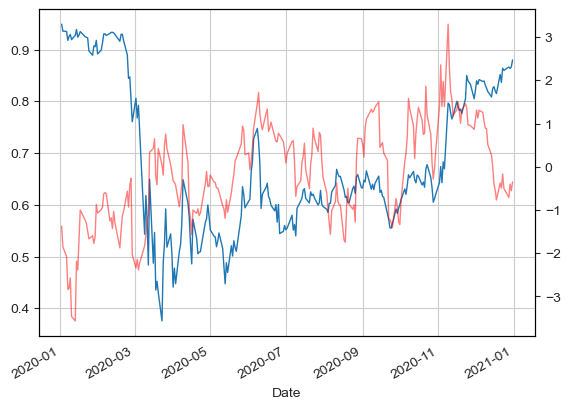

In [19]:
ticker = "JPM"

ax = stock_rets[ticker].reindex(s_scores.index).cumsum().loc["2020"].plot()
s_scores[ticker].loc["2020"].plot(ax=ax.twinx(), grid=False, color="r", alpha=.5)

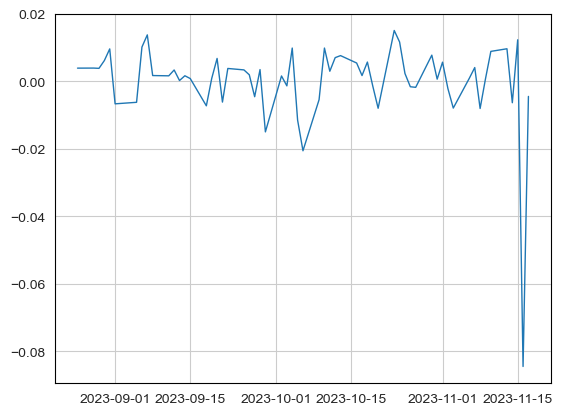

In [24]:
plt.plot(pd.DataFrame(e, index=stock_rets.index[-len(e):]))

In [11]:
signals = pd.DataFrame(columns=stock_rets.columns, index=stock_rets.index[window:])

for date in tqdm(signals.index):

    positions = {stock: 0 for stock in stocks}
    pos = 0

    for stock in stocks:

        s = s_scores.loc[date, stock]
        
        if s > 1.25:
            pos = -1
            positions[stock] = pos
        elif s < -1.25:
            pos = 1
            positions[stock] = pos
        elif s > -0.5 and pos == 1:
            pos = 0
            positions[stock] = pos
        elif s < 0.75 and pos == -1:
            pos = 0
            positions[stock] = pos
        else:
            positions[stock] = pos
        
    signals.loc[date] = positions

weights = signals.copy()

for date in weights.index:
    w = weights.loc[date]
    w[w > 0] /= sum(w > 0)
    w[w < 0] /= sum(w < 0)

weights = weights.shift()[1:]

weights.head()

  0%|          | 0/443 [00:00<?, ?it/s]

,AAPL,AMZN,BRK-B,DIS,GOOGL,HD,JNJ,JPM,MA,META,MSFT,NVDA,PG,V,WMT
Date,,,,,,,,,,,,,,,
2016-01-11,0,0,-0.2,0,0,0,0,0,-0.2,0,0,0,-0.2,-0.2,-0.2
2016-01-12,0,0,-0.5,0,0,0,0,0,0,0,0,0,0,0,-0.5
2016-01-13,0,0,-0.333333,0,0,0,0,0,-0.333333,0,0,0,0,0,-0.333333
2016-01-14,0,1.0,-0.333333,0,0,0,0,0,-0.333333,0,0,0,0,0,-0.333333
2016-01-15,0,1.0,-0.333333,0,0,0,0,0,-0.333333,0,0,0,0,0,-0.333333


In [12]:
for i, etf in enumerate(etfs):
    weights[etf] = -np.stack((betas[1:] * weights).sum(axis=1))

In [128]:
weights

,AAPL,AMZN,BRK-B,DIS,GOOGL,HD,JNJ,JPM,MA,META,MSFT,NVDA,PG,V,WMT,Adj Close
Date,,,,,,,,,,,,,,,,
2016-01-11,0,0,-0.2,0,0,0,0,0,-0.2,0,0,0,-0.2,-0.2,-0.2,0.877994
2016-01-12,0,0,-0.5,0,0,0,0,0,0,0,0,0,0,0,-0.5,0.715881
2016-01-13,0,0,-0.333333,0,0,0,0,0,-0.333333,0,0,0,0,0,-0.333333,0.875579
2016-01-14,0,1.0,-0.333333,0,0,0,0,0,-0.333333,0,0,0,0,0,-0.333333,-0.450399
2016-01-15,0,1.0,-0.333333,0,0,0,0,0,-0.333333,0,0,0,0,0,-0.333333,-0.486134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-13,0,0,0,-1.0,0.25,0.25,0,0,0.25,0.25,0,0,0,0,0,-0.626902
2023-11-14,0,0,0,-1.0,0.25,0.25,0,0,0.25,0.25,0,0,0,0,0,-0.597388
2023-11-15,0,0,0,-1.0,0.333333,0,0,0,0.333333,0.333333,0,0,0,0,0,-0.619414


<Axes: xlabel='Date'>

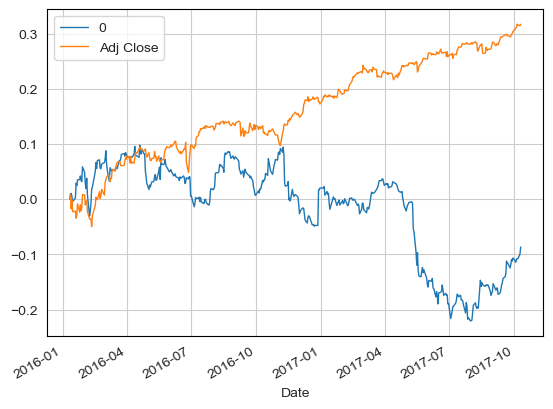

In [13]:
all_rets = pd.concat([stock_rets, etf_rets], axis=1).reindex(weights.index)

raw_algo_rets = (all_rets * weights).sum(axis=1)
abs_weights_sum = weights.abs().sum(axis=1)
abs_weights_sum[abs_weights_sum == 0] = np.nan

algo_rets = (raw_algo_rets).fillna(0)

backtest = pd.concat([algo_rets, etf_rets], axis=1).dropna()
backtest.loc[backtest.index.min()] = 0

backtest.cumsum().plot()

**Ornstein-Uhlenbeck process:**

$dX_t = \theta(\mu - X_t)dt + \sigma{d}{W}_t$

**Regressing stock vs. market:**

$R_{it}=\beta_{i, m} R_{mt} + \alpha + \epsilon_{t}$

**Taking the cumulative sum of $\epsilon$:**

$\rightarrow E_T = \sum_{t=1}^T\epsilon_{t}$

**Long term mean:**

$\rightarrow \Epsilon_{t} = b \cdot \Epsilon_{t-1} + a + z\\$

To find the long term mean, $E_{t} = E_{t-1} = M$ and $z=0$:

$\rightarrow M = b \cdot M + a + 0\\
\rightarrow  M - b \cdot M = a\\
\rightarrow M(1 - b) = a\\
\rightarrow M = \frac{a}{1-b}$

**$\kappa$, speed of mean reversion:**

$\rightarrow\kappa = -\log(b)$

**Variance:**

$\rightarrow\sigma_{\text{equilibrium}} = \sqrt{\frac{\sigma_{z}^2}{1 - b^2}}$